In [ ]:
#less go

In [1]:
print('les go')

les go


In [2]:
!pip install wandb

In [3]:
!wandb login 31c7358e23c8522a5aece87ff899a31a639ef7d4
import wandb
wandb.init(project="test")

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: sandeshpokhrel (team-friday). Use `wandb login --relogin` to force relogin


In [4]:
# !pip install git+https://github.com/facebookresearch/WavAugment
!pip install torchaudio-augmentations

# 
# !wget http://opihi.cs.uvic.ca/sound/genres.tar.gz
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/valid_filtered.txt
!wget https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/test_filtered.txt    


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 686.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21894 sha256=9715509c8d6280012805505cb78eb31b8f72262f2981e0cfe8cd9bef17f49238
  Stored in directory: /root/.cache/pip/wheels/44/52/2c/7dd069f82c7f905f40b190a8039ec2a17fdd4bb009c57c6664
Successfully built julius
--2022-12-28 03:32:43--  https://raw.githubusercontent.com/coreyker/dnn-mgr/master/gtzan/train_filtered.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10152 (9.9K) [text/plain]
Saving to: ‘train_filtered.txt’

train_filtered.txt  100%[===================>]   9.91K  --.-KB/s    in 0s      

2022-12-28 03:32:44 (53.2 MB/s) - ‘train_filtered.txt’ sav

In [5]:
#rename
def rname(fname):
    dirnfile= fname.split('/')
    directory = dirnfile[0]
    f = dirnfile[1].split('.')
    
#     print(f)
    file = f'{f[0]}_{f[0]}_{f[1]}.wav'
#     print(file)
    return file
    
#edit filtered
with open('/kaggle/working/train_filtered.txt') as f:
    lines = f.readlines()
    song_list = [line.strip() for line in lines]
#     rname(song_list[0])
    song_list_cleaned = map(rname, song_list)
#     print(list(song_list_cleaned))
    

In [6]:
import os
import random
import torch
import numpy as np
import soundfile as sf
import librosa
from torch.utils import data
from torchaudio_augmentations import (
RandomResizedCrop,
RandomApply,
PolarityInversion,
Noise,
Gain,
HighLowPass,
Delay,
PitchShift,
Reverb,
Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
NEP_GENRES = ['classical','adhunik','lok dohori','filmy','bhajan']


In [7]:
# sf.available_formats()

In [8]:
class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path = data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self.buffer = None
        self._get_song_list()
        
        if is_augmentation:
            self._get_augmentations()
        
    def _get_song_list(self):
        list_filename = f'/kaggle/working/{self.split}_filtered.txt'
        
        with open(list_filename) as f:
            lines = f.readlines()
            song_list = [line.strip() for line in lines]
            rname(song_list[0])
            song_list_cleaned = map(rname, song_list)
#             print(list(song_list_cleaned))
            self.song_list = list(song_list_cleaned)
        
#         with open(list_filename) as f:
#             lines = f.readlines()
#         self.song_list = [line.strip() for line in lines]
#         print(self.song_list)
            
    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)
            
    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i*hop: i*hop + self.num_samples] for i in range(self.num_chunks)])
        return wav
        
    def __getitem__(self, index):
        line= self.song_list[index]

#         print(line)
        #get genre
        
        genre_name = line.split('_')[0]
#         print(genre_name)
        genre_index = self.genres.index(genre_name)
        
        #get audio
        audio_filename= os.path.join(self.data_path, 'genres_original',genre_name, line)
#         print(audio_filename)
#         wav, fs = sf.read(audio_filename)
        try:
            wav, fs = librosa.load(audio_filename)
            
            #adjust audio length
            wav = self._adjust_audio_length(wav).astype('float32')

            #data augmentation
            if self.is_augmentation:
                wav = self.augmentation(torch.from_numpy(wav).unsqueeze(0))
            
            self.buffer = (wav, genre_index)
            
            return wav, genre_index
        
        
        except:
            
            print("bad file; return buffer file to batch")
            return self.buffer[0], self.buffer[1]
            
    
#         except:
#             print("bad file error")
#             return None
        
    def __len__(self):
        return len(self.song_list)    
        

In [9]:
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

In [10]:
#dataloader
def get_dataloader(data_path='/kaggle/input/gtzanpreprocessed/Data/Data',
                  split='train',
                  num_samples=22050*29,
                  num_chunks=1,
                  batch_size=16,
                  num_workers=0,
                  is_augmentation=False,
                  collate_fn = collate_fn):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split=='train') else (batch_size//num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path,
                                                      split,
                                                      num_samples,
                                                      num_chunks,
                                                      is_augmentation),
                                 batch_size = batch_size,
                                 shuffle=is_shuffle,
                                 drop_last=False,
                                 num_workers=num_workers)
    return data_loader


In [11]:
train_loader = get_dataloader(split='train', is_augmentation=True)
iter_train_loader = iter(train_loader)
train_wav, train_genre = next(iter_train_loader)

valid_loader = get_dataloader(split='valid')
test_loader = get_dataloader(split='test')
iter_test_loader = iter(test_loader)

test_wav, test_genre = next(iter_test_loader)
print('training data shape: %s' %str(train_wav.shape))
print('validation/test data shape: %s' %str(test_wav.shape))
print(train_genre)



training data shape: torch.Size([16, 1, 639450])
validation/test data shape: torch.Size([16, 1, 639450])
tensor([4, 2, 7, 3, 6, 4, 5, 2, 0, 3, 9, 6, 2, 9, 5, 7])


In [12]:
#model
from torch import nn

class Conv_2d(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, wav):
        out= self.conv(wav)
        out= self.bn(out)
        out= self.relu(out)
        out= self.maxpool(out)
        out= self.dropout(out)
        return out
        

In [13]:
from PIL import Image
import torchvision.transforms as T

def save_test_spec(testing):
# testing = torch.randn((16,1,128,1249))
#     print(testing.shape)
    stripped_test = testing.squeeze(1)
#     print(stripped_test[0].shape)
    new = stripped_test[0]
    new = new.unsqueeze(0)
# print(new.shape)
    transform = T.ToPILImage()
    img = transform(new)
    img.save('/kaggle/working/test.png')

In [14]:
import torchaudio

class CNN(nn.Module):
    def __init__(self, num_channels=16,
              sample_rate = 22050,
              n_fft=1024,
              f_min=0.0,
              f_max=11025.0,
              num_mels=128,
              num_classes=10):
        
        super(CNN,self).__init__()
        
        #mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                           n_fft=n_fft,
                                                           f_min=f_min,
                                                           f_max=f_max,
                                                           n_mels=num_mels) 
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()  #cepstral coefficients
        self.input_bn = nn.BatchNorm2d(1)
        
        #convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2,3))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3,4))
        self.layer3 = Conv_2d(num_channels, num_channels*2, pooling=(2,5))
        self.layer4 = Conv_2d(num_channels*2, num_channels*2, pooling=(3,3))
        self.layer5 = Conv_2d(num_channels*2, num_channels*4, pooling=(3,4))
        
        #dense layers
        self.dense1 = nn.Linear(num_channels*4, num_channels*4)
        self.dense_bn = nn.BatchNorm1d(num_channels*4)
        self.dense2 = nn.Linear(num_channels*4, num_classes) #maybe try softmax here
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        
    def forward(self,wav):
        #input processing
        
#         print(wav.shape)
        out = self.melspec(wav)
#         print(out.shape)
#         copy = torch.clone(out)
#         copy.to('cpu')
#         save_test_spec(copy)
        
        out = self.amplitude_to_db(out)
        #input batch
#       out = out.unsqueeze(1)
#         print(out.shape)
#         out = torch.permute(out, (0,3,2,1))
#         print(out.shape)
        out = self.input_bn(out)
#         print(out.shape)

        #convlayers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)

        # reshape. (batch_size, num_channels, 1, 1) -> (batch_size, num_channels)
        out = out.reshape(len(out), -1)

        #dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)
        
        return out
        

In [15]:
#transform for resnet18 model

from PIL import Image
from torchvision import transforms

# input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize((224, 1249)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# input_tensor = preprocess(input_image)
# input_batch = input_tensor.unsqueeze(0)

In [16]:
#lets try resnet

class CNN_modified(nn.Module):
    def __init__(self, num_channels=16,
              sample_rate = 22050,
              n_fft=1024,
              f_min=0.0,
              f_max=11025.0,
              num_mels=128,
              num_classes=10):
        
        super(CNN_modified,self).__init__()
        
        #mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate,
                                                           n_fft=n_fft,
                                                           f_min=f_min,
                                                           f_max=f_max,
                                                           n_mels=num_mels) 
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()  #cepstral coefficients
        self.input_bn = nn.BatchNorm2d(1)
        self.resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False) #changed no of input channels

        
        #convolutional layers
#         self.layer1 = Conv_2d(1, num_channels, pooling=(2,3))
#         self.layer2 = Conv_2d(num_channels, num_channels, pooling=(3,4))
#         self.layer3 = Conv_2d(num_channels, num_channels*2, pooling=(2,5))
#         self.layer4 = Conv_2d(num_channels*2, num_channels*2, pooling=(3,3))
#         self.layer5 = Conv_2d(num_channels*2, num_channels*4, pooling=(3,4))
#         self.layer1 = self.resnet_model()
    
        #dense layers
#         self.dense1 = nn.Linear(num_channels*4, num_channels*4)
#         self.dense_bn = nn.BatchNorm1d(num_channels*4)
#         self.dense2 = nn.Linear(num_channels*4, num_classes) #maybe try softmax here
#         self.dropout = nn.Dropout(0.5)
#         self.relu = nn.ReLU()
        
        
    def forward(self,wav):
        #input processing
        
#         print(wav.shape)
        out = self.melspec(wav)
#         print(out.shape)
#         copy = torch.clone(out)
#         copy.to('cpu')
#         save_test_spec(copy)
        
        #make sure to reshape to at least 224x224 and normalizing with suggested standard deviation and mean
        
        #WRITE THAT FUNC
        
        out = self.amplitude_to_db(out)
        #input batch
#       out = out.unsqueeze(1)
#         print(out.shape)
#         out = torch.permute(out, (0,3,2,1))
#         print(out.shape)
        out = self.input_bn(out)
#         print(out.shape)
        
        
        
        #convlayers
        print(out.shape)
        out = self.resnet_model(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = self.resnet_model(out) #trying directly without normalizing inputs or the shape of image
        
        return out


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# cnn = CNN().to(device)
cnn = CNN_modified().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
valid_losses = []
num_epochs = 100

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


In [ ]:
#training
for epoch in range(num_epochs):
    train_losses = []
    
    #Train
    cnn.train()
    for (wav, genre_index) in train_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        #forward
        out= cnn(wav)
        loss= loss_function(out, genre_index)

        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        mean_train_losses = np.mean(train_losses)
    print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, mean_train_losses))
    
    
    #validation
    cnn.eval()
    y_true = []
    y_pred = []
    valid_losses = []
    
    for wav, genre_index in valid_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)

        #reshape and aggregate chunk-level predictions
        b, c, t = wav.size()
        
        check = wav.view(-1,t)
#         print(check.shape)
        
#         logits = cnn(wav.view(-1,t))
        logits = cnn(wav)
        logits = logits.view(b, c, -1).mean(dim=1)
        loss = loss_function(logits, genre_index)
        valid_losses.append(loss.item())
        _, pred = torch.max(logits.data,1)


        #append
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
    accuracy = accuracy_score(y_true, y_pred)
    valid_loss = np.mean(valid_losses)
    print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy %.4f' % (epoch+1, num_epochs, valid_loss, accuracy))
        
    #save model
    valid_losses.append(valid_loss.item())
    if(epoch%5 == 0):
        name = 'model_'+ str(epoch)+'.ckpt'
    torch.save(cnn.state_dict(),name)
#     if np.argmin(valid_losses) == epoch:
#         print('Saving the best model at %d epochs!' % epoch)
#         torch.save(cnn.state_dict(), 'best_model.ckpt')
    
    wandb.log({"train_loss": mean_train_losses, "valid_loss":valid_loss, "accuracy":accuracy})


In [26]:
# %debug
#evaluation

S = torch.load('/kaggle/input/gtzanpreprocessed/model_40.ckpt')
# print(S)
cnn.load_state_dict(S, strict=False)

print('loaded!')

#Run evaluation

cnn.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for wav, genre_index in test_loader:
        wav = wav.to(device)
        genre_index = genre_index.to(device)
        
        #reshape and aggregate chunk- level predictions
        b, c, t = wav.size()
#         print("b,c,t",b,c,t)
#         logits = cnn(wav.view(-1, t))
        print("wav.view(-1,t).shape",wav.view(-1,t).shape)
        logits = cnn(wav)
        print("logits", logits)
#         logits = logits.view(b, c, -1).mean(dim=1)
        print("logits data",logits.data)
        _, pred = torch.max(logits.data, 1)
        print("predictions", pred)
        #append labels and predictions
        y_true.extend(genre_index.tolist())
        y_pred.extend(pred.tolist())
#         print(y_pred)


loaded!
wav.view(-1,t).shape torch.Size([16, 639450])
torch.Size([16, 1, 128, 1249])
logits tensor([[  5.6276,  10.1088,   0.5326,  ..., -13.8730, -14.6433, -12.6785],
        [  6.4343,   8.5896,  -0.0948,  ..., -14.3921, -15.0611, -13.3208],
        [  7.4438,   5.0721,   1.7387,  ..., -15.0236, -15.5910, -14.4641],
        ...,
        [  5.9166,   8.7332,  -0.8728,  ..., -16.7917, -17.4445, -16.1245],
        [  8.0743,   7.1470,  -0.5836,  ..., -17.0147, -17.7209, -16.5845],
        [  7.0007,   7.5791,   2.3751,  ..., -16.3444, -17.1547, -15.6795]],
       device='cuda:0')
logits data tensor([[  5.6276,  10.1088,   0.5326,  ..., -13.8730, -14.6433, -12.6785],
        [  6.4343,   8.5896,  -0.0948,  ..., -14.3921, -15.0611, -13.3208],
        [  7.4438,   5.0721,   1.7387,  ..., -15.0236, -15.5910, -14.4641],
        ...,
        [  5.9166,   8.7332,  -0.8728,  ..., -16.7917, -17.4445, -16.1245],
        [  8.0743,   7.1470,  -0.5836,  ..., -17.0147, -17.7209, -16.5845],
        [

Accuracy: 0.6207


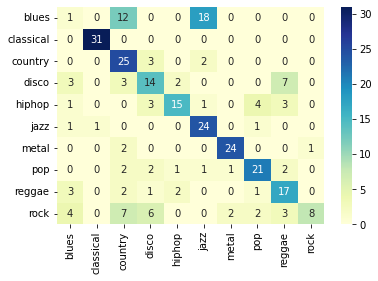

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# print(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)